# Frequentism and Bayesianism III: Confidence, Credibility and why Frequentism and Science Don't Mix

**Mario Juric, University of Washington**

**e-mail: <mjuric@astro.washington.edu>, twitter: [@mjuric](http://twitter.com/mjuric)**

---

*This lecture series is almost entirely based on a [post](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/) on the blog [Pythonic Perambulations](http://jakevdp.github.io), by [Jake VanderPlas](https://staff.washington.edu/jakevdp/). The content is BSD licensed. See also VanderPlas (2014) ["Frequentism and Bayesianism: A Python-driven Primer"](http://arxiv.org/abs/1411.5018).*

*Slides built using the excellent [RISE](https://github.com/damianavila/RISE) Jupyter extension by [Damian Avila](https://github.com/damianavila).*

In Douglas Adams' classic *Hitchhiker's Guide to the Galaxy*, hyper-intelligent pan-dimensional beings build a computer named *Deep Thought* in order to calculate "the Answer to the Ultimate Question of Life, the Universe, and Everything".

After seven and a half million years spinning its hyper-dimensional gears, before an excited crowd, Deep Thought finally outputs the answer:

<big><center>**42**</center></big>

The disappointed technicians, who trained a lifetime for this moment, are stupefied. They probe Deep Though for more information, and after some back-and-forth, the computer responds: "once you do know what the question actually is, you'll know what the answer means."

**An answer does you no good if you don't know the question.**

This story is an apt metaphor for statistics as sometimes used in the scientific literature.

When trying to estimate the value of an unknown parameter, the frequentist approach generally relies on a **confidence interval** (CI), while the Bayesian approach relies on a **credible region** (CR).

While these concepts sound and look very similar, their subtle difference can be extremely important, as they answer essentially different questions.

Like the poor souls hoping for enlightenment in Douglas Adams' universe, scientists often turn the crank of frequentism hoping for useful answers, but in the process overlook the fact that in science, **frequentism is generally answering the wrong question.**

This is far from simple philosophical navel-gazing: as I'll show, it can have real consequences for the conclusions we draw from observed data.

## Confidence vs. Credibility

In the first part of this lecture, we discussed the basic philosophical difference between frequentism and Bayesianism: frequentists consider probability a measure of **the frequency of (perhaps hypothetical) repeated events**; Bayesians consider probability as a measure of **the degree of certainty about values**. As a result of this, speaking broadly, frequentists consider **model parameters to be fixed and data to be random**, while Bayesians consider **model parameters to be random and data to be fixed**.

These philosophies fundamenally affect the way that each approach seeks bounds on the value of a model parameter. Because the differences here are subtle, let's go right into a simple example to illustrate the difference between a frequentist confidence interval and a Bayesian credible region.

## Example 1: The Mean of a Gaussian

Let's start by again examining an extremely simple problem; this is the same problem we saw in [part I](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) of this series: finding the mean of a Gaussian distribution. Previously we simply looked at the (frequentist) maximum likelihood and (Bayesian) maximum a posteriori estimates; here we'll extend this and look at confidence intervals and credibile regions.

Here is the problem: imagine you're observing a star that you assume has a constant brightness. Simplistically, we can think of this brightness as the number of photons reaching our telescope in one second.  Any given measurement of this number will be subject to measurement errors: the source of those errors is not important right now, but let's assume the observations $x_i$ are drawn from a normal distribution about the true brightness value with a known standard deviation $\sigma_x$.

Given a series of measurements, what are the 95% (i.e. $2\sigma$) limits that we would place on the brightness of the star?

### 1. The Frequentist Approach

The frequentist approach to this problem is well-known, and is as follows:

For any set of $N$ values $D = \{x_i\}_{i=1}^N$, an unbiased estimate of the mean $\mu$ of the distribution is given by

$$
\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i
$$

The **sampling distribution** describes the observed frequency of the estimate of the mean; by the central limit theorem we can show that the sampling distribution is normal; i.e.

$$
f(\bar{x}~||~\mu) \propto \exp\left[\frac{-(\bar{x} - \mu)^2}{2\sigma_\mu^2}\right]
$$

where we've used the **standard error of the mean**,

$$
\sigma_\mu = \sigma_x / \sqrt{N}
$$

The central limit theorem tells us that this is a reasonable approximation for any generating distribution if $N$ is large; if our generating distribution happens to be Gaussian, it also holds for $N$ as small as 2.

Let's quickly check this empirically, by looking at $10^6$ samples of the mean of 5 numbers:

In [1]:
import numpy as np

N = 5
Nsamp = 10 ** 6
sigma_x = 2

np.random.seed(0)
x = np.random.normal(0, sigma_x, size=(Nsamp, N))
mu_samp = x.mean(1)
sig_samp = sigma_x * N ** -0.5

print("{0:.3f} should equal {1:.3f}".format(np.std(mu_samp), sig_samp))

0.894 should equal 0.894


It checks out: the standard deviation of the observed means is equal to $\sigma_x N^{-1/2}$, as expected.

From this normal sampling distribution, we can quickly write the 95% confidence interval by recalling that two standard deviations is roughly equivalent to 95% of the area under the curve. So our confidence interval is

$$
CI_{\mu} =  \left(\bar{x} - 2\sigma_\mu,~\bar{x} + 2\sigma_\mu\right)
$$

Let's try this with a quick example: say we have three observations with an error (i.e. $\sigma_x$) of 10. What is our 95% confidence interval on the mean?

We'll generate our observations assuming a true value of 100:

In [2]:
true_B = 100
sigma_x = 10

np.random.seed(1)
D = np.random.normal(true_B, sigma_x, size=3)
print(D)

[ 116.24345364   93.88243586   94.71828248]


Next let's create a function which will compute the confidence interval:

In [3]:
from scipy.special import erfinv

def freq_CI_mu(D, sigma, frac=0.95):
    """Compute the confidence interval on the mean"""
    # we'll compute Nsigma from the desired percentage
    Nsigma = np.sqrt(2) * erfinv(frac)
    mu = D.mean()
    sigma_mu = sigma * D.size ** -0.5
    return mu - Nsigma * sigma_mu, mu + Nsigma * sigma_mu

print("95% Confidence Interval: [{0:.0f}, {1:.0f}]".format(*freq_CI_mu(D, 10)))

95% Confidence Interval: [90, 113]


Note here that we've assumed $\sigma_x$ is a known quantity; this could also be estimated from the data along with $\mu$, but here we kept things simple for sake of example.

### 2. The Bayesian Approach

For the Bayesian approach, we start with Bayes' theorem:

$$
P(\mu~|~D) = \frac{P(D~|~\mu)P(\mu)}{P(D)}
$$

We'll use a flat prior on $\mu$ (i.e. $P(\mu) \propto 1$ over the region of interest) and use the likelihood

$$
P(D~|~\mu) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_x^2}}\exp\left[\frac{(\mu - x_i)^2}{2\sigma_x^2}\right]
$$

Computing this product and manipulating the terms, it's straightforward to show that this gives

$$
P(\mu~|~D) \propto \exp\left[\frac{-(\mu - \bar{x})^2}{2\sigma_\mu^2}\right]
$$

which is recognizable as a normal distribution with mean $\bar{x}$ and standard deviation $\sigma_\mu$.
That is, **the Bayesian posterior on $\mu$ in this case is exactly equal to the frequentist sampling distribution for $\mu$**.

From this posterior, we can compute the Bayesian credible region, which is the shortest interval that contains 95% of the probability. Here, it looks exactly like the frequentist confidence interval:

$$
CR_{\mu} =  \left(\bar{x} - 2\sigma_\mu,~\bar{x} + 2\sigma_\mu\right)
$$

For completeness, we'll also create a function to compute the Bayesian credible region:

In [4]:
def bayes_CR_mu(D, sigma, frac=0.95):
    """Compute the credible region on the mean"""
    Nsigma = np.sqrt(2) * erfinv(frac)
    mu = D.mean()
    sigma_mu = sigma * D.size ** -0.5
    return mu - Nsigma * sigma_mu, mu + Nsigma * sigma_mu

print("95% Credible Region: [{0:.0f}, {1:.0f}]".format(*bayes_CR_mu(D, 10)))

95% Credible Region: [90, 113]


### So What's the Difference?

The above derivation is one reason why the frequentist confidence interval and the Bayesian credible region are so often confused. In many simple problems, they correspond exactly. But we must be clear that **even though the two are numerically equivalent, their interpretation is very different**.

Recall that in Bayesianism, the probability distributions reflect our degree of belief. So when we computed the credible region above, it's equivalent to saying

> "Given our observed data, there is a 95% probability that the true value of $\mu$ falls within $CR_\mu$" - Bayesians

In frequentism, on the other hand, $\mu$ is considered a fixed value and the data (and all quantities derived from the data, including the bounds of the confidence interval) are random variables. So the frequentist confidence interval is equivalent to saying

> "There is a 95% probability that when I compute $CI_\mu$ from data of this sort, the true mean will fall within $CI_\mu$." - Frequentists

Note the difference: the Bayesian solution is a statement of probability about the parameter value given fixed bounds. The frequentist solution is a probability about the bounds given a fixed parameter value. This follows directly from the philosophical definitions of probability that the two approaches are based on.

The difference is subtle, but, as I'll discuss below, it has drastic consequences. First, let's further clarify these notions by running some simulations to confirm the interpretation.

#### Confirming the Bayesian Credible Region

To confirm what the Bayesian credible region is claiming, we must do the following:

1. sample random $\mu$ values from the prior
2. sample random sets of points given each $\mu$
3. select the sets of points which match our observed data
3. ask what fraction of these $\mu$ values are within the credible region we've constructed.

In code, that looks like this:

In [5]:
# first define some quantities that we need 
Nsamples = int(2E7)
N = len(D)
sigma_x = 10

# if someone changes N, this could easily cause a memory error
if N * Nsamples > 1E8:
    raise ValueError("Are you sure you want this many samples?")
    
# eps tells us how close to D we need to be to consider
# it a matching sample. The value encodes the tradeoff
# between bias and variance of our simulation
eps = 0.5

# Generate some mean values from the (flat) prior in a reasonable range
np.random.seed(0)
mu = 80 + 40 * np.random.random(Nsamples)

# Generate data for each of these mean values
x = np.random.normal(mu, sigma_x, (N, Nsamples)).T

# find data which matches matches our "observed" data
x.sort(1)
D.sort()
i = np.all(abs(x - D) < eps, 1)
print("number of suitable samples: {0}".format(i.sum()))

number of suitable samples: 528


In [6]:
# Now we ask how many of these mu values fall in our credible region
mu_good = mu[i]
CR = bayes_CR_mu(D, 10)
within_CR = (CR[0] < mu_good) & (mu_good < CR[1])
print "Fraction of means in Credible Region: {0:.3f}".format(within_CR.sum() * 1. / within_CR.size)

Fraction of means in Credible Region: 0.949


We see that, as predicted, roughly 95% of $\mu$ values with data matching ours lie in the Credible Region.

The important thing to note here is which of the variables is random, and which are fixed. In the Bayesian approach, we compute **a single credible region from our observed data**, and we consider it in terms of **multiple random draws of $\mu$**.

#### Confirming the frequentist Confidence Interval

Confirmation of the interpretation of the frequentist confidence interval is a bit less involved. We do the following:

1. draw sets of values from the distribution defined by the single true value of $\mu$.
2. for each set of values, compute a new confidence interval.
3. determine what fraction of these confidence intervals contain $\mu$.

In code, it looks like this:

In [7]:
# define some quantities we need
N = len(D)
Nsamples = int(1E4)
mu = 100
sigma_x = 10

# Draw datasets from the true distribution
np.random.seed(0)
x = np.random.normal(mu, sigma_x, (Nsamples, N))

# Compute a confidence interval from each dataset
CIs = np.array([freq_CI_mu(Di, sigma_x) for Di in x])

# find which confidence intervals contain the mean
contains_mu = (CIs[:, 0] < mu) & (mu < CIs[:, 1])
print "Fraction of Confidence Intervals containing the mean: {0:.3f}".format(contains_mu.sum() * 1. / contains_mu.size)

Fraction of Confidence Intervals containing the mean: 0.951


We see that, as predicted, 95% of the confidence intervals contain the true value of $\mu$.

Again, the important thing to note here is which of the variables is random. We use **a single value of $\mu$**, and consider it in relation to **multiple confidence intervals constructed from multiple random data samples**.

### Discussion

We should remind ourselves again of the difference between the two types of constraints:

- The Bayesian approach fixes the credible region, and guarantees 95% of possible values of $\mu$ will fall within it.
- The frequentist approach fixes the parameter, and guarantees that 95% of possible confidence intervals will contain it.

Comparing the frequentist confirmation and the Bayesian confirmation above, we see that the distinctions which stem from the very definition of probability mentioned above:

- Bayesianism treats parameters (e.g. $\mu$) as random variables, while frequentism treats parameters as fixed.
- Bayesianism treats observed data (e.g. $D$) as fixed, while frequentism treats data as random variables.
- Bayesianism treats its parameter constraints (e.g. $CR_\mu$) as fixed, while frequentism treats its constraints (e.g. $CI_\mu$) as random variables.

In the above example, as in many simple problems, the confidence interval and the credibility region overlap exactly, so the distinction is not especially important. But scientific analysis is rarely this simple; next we'll consider an example in which the choice of approach makes a big difference.

## Example 2: Jaynes' Truncated Exponential

For an example of a situation in which the frequentist confidence interval and the Bayesian credibility region *do not* overlap, I'm going to turn to an example given by E.T. Jaynes, a 20th century physicist who wrote extensively on statistical inference in Physics.  In the fifth example of his *Confidence Intervals vs. Bayesian Intervals* ([pdf](http://bayes.wustl.edu/etj/articles/confidence.pdf)), he considers a truncated exponential model. Here is the problem, in his words:

> A device will operate without failure for a time $\theta$ because of a protective chemical inhibitor injected into it; but at time $\theta$ the supply of the chemical is exhausted, and failures then commence, following the exponential failure law. It is not feasible to observe the depletion of this inhibitor directly; one can observe only the resulting failures. From data on actual failure times, estimate the time $\theta$ of guaranteed safe operation...

Essentially, we have data $D$ drawn from the following model:

$$
p(x~|~\theta) = \left\{
\begin{array}{lll}
\exp(\theta - x) &,& x > \theta\\
0                &,& x < \theta
\end{array}
\right\}
$$

where $p(x~|~\theta)$ gives the probability of failure at time $x$, given an inhibitor which lasts for a time $\theta$.
Given some observed data $D = \{x_i\}$, we want to estimate $\theta$.

Let's start by plotting this model for a particular value of $\theta$, so we can see what we're working with:

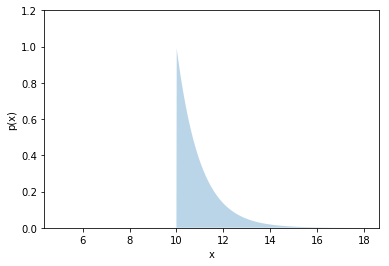

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def p(x, theta):
    return (x > theta) * np.exp(theta - x)

x = np.linspace(5, 18, 1000)
plt.fill(x, p(x, 10), alpha=0.3)
plt.ylim(0, 1.2)
plt.xlabel('x')
plt.ylabel('p(x)');

Imagine now that we've observed some data, $D = \{10, 12, 15\}$, and we want to infer the value of $\theta$ from this data. We'll explore four approaches to this below.

### 1. Common Sense Approach

One general tip that I'd always recommend: in any problem, before computing anything, think about what you're computing and guess what a reasonable solution might be. We'll start with that here. Thinking about the problem, the hard cutoff in the probability distribution leads to one simple observation: **$\theta$ must be smaller than the smallest observed value**.

This is immediately obvious on examination: the probability of seeing a value less than $\theta$ is zero.  Thus, a model with $\theta$ greater than any observed value is impossible, assuming our model specification is correct. Our fundamental assumption in both Bayesianism and frequentism is that the model is correct, so in this case, we can immediately write our common sense condition:

$$
\theta < \min(D)
$$

or, in the particular case of $D = \{10, 12, 15\}$,

$$
\theta < 10
$$

Any reasonable constraint on $\theta$ given this data should meet this criterion. With this in mind, let's go on to some quantitative approaches based on Frequentism and Bayesianism.

### 2. Frequentist approach #1: Sampling Distribution via the Normal Approximation

In the frequentist paradigm, we'd like to compute a confidence interval on the value of $\theta$. We can start by observing that the population mean is given by

$$
\begin{array}{ll}
E(x) &= \int_0^\infty xp(x)dx\\
     &= \theta + 1
     \end{array}
$$

So, using the sample mean as the point estimate of $E(x)$, we have an unbiased estimator for $\theta$ given by

$$
\hat{\theta} = \frac{1}{N} \sum_{i=1}^N x_i - 1
$$

The exponential distribution has a standard deviation of 1, so in the limit of large $N$, we can use the standard error of the mean (as above) to show that the sampling distribution of $\hat{\theta}$ will approach normal with variance $\sigma^2 = 1 / N$. Given this, we can write our 95% (i.e. 2$\sigma$) confidence interval as

$$
CI_{\rm large~N} = \left(\hat{\theta} - 2 N^{-1/2},~\hat{\theta} + 2 N^{-1/2}\right)
$$

Let's write a function which will compute this, and evaluate it for our data:

In [9]:
from scipy.special import erfinv

def approx_CI(D, sig=0.95):
    """Approximate truncated exponential confidence interval"""
    # use erfinv to convert percentage to number of sigma
    Nsigma = np.sqrt(2) * erfinv(sig)
    D = np.asarray(D)
    N = D.size
    theta_hat = np.mean(D) - 1
    return [theta_hat - Nsigma / np.sqrt(N),
            theta_hat + Nsigma / np.sqrt(N)]

In [10]:
D = [10, 12, 15]
print("approximate CI: ({0:.1f}, {1:.1f})".format(*approx_CI(D)))

approximate CI: (10.2, 12.5)


We immediately see an issue. By our simple common sense argument, we've determined that it is impossible for $\theta$ to be greater than 10, yet the entirety of the 95% confidence interval is above this range!  Perhaps this issue is due to the small sample size: the above computation is based on a large-$N$ approximation, and we have a relatively paltry $N = 3$.

Maybe this will be improved if we do the more computationally intensive exact approach?

The answer is no. If we compute the confidence interval without relying on large-$N$ Gaussian eapproximation, the result is $(10.2, 12.2)$.

Note: you can verify yourself by evaluating the code in the sub-slides.

### 3. Frequentist approach #2: Exact Sampling Distribution

Computing the confidence interval from the exact sampling distribution takes a bit more work.

For small $N$, the normal approximation will not apply, and we must instead compute the confidence integral from the actual sampling distribution, which is the distribution of the mean of $N$ variables each distributed according to $p(\theta)$. The sum of random variables is distributed according to the convolution of the distributions for individual variables, so we can exploit the [convolution theorem](http://en.wikipedia.org/wiki/Convolution_theorem) and use the method of [characteristic functions](http://en.wikipedia.org/wiki/Characteristic_function_%28probability_theory%29) to find the following sampling distribution for the sum of $N$ variables distributed according to our particular $p(x~|~\theta)$:

$$
f(\theta~|~D) \propto
\left\{
\begin{array}{lll}
z^{N - 1}\exp(-z) &,& z > 0\\
0 &,& z < 0
\end{array}
\right\}
;~ z = N(\hat{\theta} + 1 - \theta)
$$

To compute the 95% confidence interval, we can start by computing the cumulative distribution: we integrate $f(\theta~|~D)$ from $0$ to $\theta$ (note that we are not actually integrating over the *parameter* $\theta$, but over the *estimate* of $\theta$. Frequentists cannot integrate over parameters).
This integral is relatively painless if we make use of the expression for the [incomplete gamma function](http://en.wikipedia.org/wiki/Incomplete_gamma_function):

$$
\Gamma(a, x) = \int_x^\infty t^{a - 1}e^{-t} dt
$$

which looks strikingly similar to our $f(\theta)$.

Using this to perform the integral, we find that the cumulative distribution is given by

$$
F(\theta~|~D) = \frac{1}{\Gamma(N)}\left[ \Gamma\left(N, \max[0, N(\hat{\theta} + 1 - \theta)]\right) - \Gamma\left(N,~N(\hat{\theta} + 1)\right)\right]
$$

A contiguous 95% confidence interval $(\theta_1, \theta_2)$ satisfies the following equation:

$$
F(\theta_2~|~D) - F(\theta_1~|~D) = 0.95
$$

There are in fact an infinite set of solutions to this; what we want is the shortest of these. We'll add the constraint that the probability density is equal at either side of the interval:

$$
f(\theta_2~|~D) = f(\theta_1~|~D)
$$

(Jaynes claims that this criterion ensures the shortest possible interval, but I'm not sure how to prove that).
Solving this system of two nonlinear equations will give us the desired confidence interval. Let's compute this numerically:

In [11]:
from scipy.special import gammaincc
from scipy import optimize


def exact_CI(D, frac=0.95):
    """Exact truncated exponential confidence interval"""
    D = np.asarray(D)
    N = D.size
    theta_hat = np.mean(D) - 1

    def f(theta, D):
        z = theta_hat + 1 - theta
        return (z > 0) * z ** (N - 1) * np.exp(-N * z)

    def F(theta, D):
        return gammaincc(N, np.maximum(0, N * (theta_hat + 1 - theta))) - gammaincc(N, N * (theta_hat + 1))
    
    def eqns(CI, D):
        """Equations which should be equal to zero"""
        theta1, theta2 = CI
        return (F(theta2, D) - F(theta1, D) - frac,
                f(theta2, D) - f(theta1, D))
    
    guess = approx_CI(D, 0.68) # use 1-sigma interval as a guess
    result = optimize.root(eqns, guess, args=(D,))
    if not result.success:
        print "warning: CI result did not converge!"
    return result.x

As a sanity check, let's make sure that the exact and approximate confidence intervals match for a large number of points:

In [12]:
np.random.seed(0)
Dlarge = 10 + np.random.random(500)
print "approx: ({0:.3f}, {1:.3f})".format(*approx_CI(Dlarge))
print "exact: ({0:.3f}, {1:.3f})".format(*exact_CI(Dlarge))

approx: (9.409, 9.584)
exact: (9.408, 9.584)


As expected, the approximate solution is very close to the exact solution for large $N$, which gives us confidence that we're computing the right thing.

Let's return to our 3-point dataset and see the results:

In [13]:
print("approximate CI: ({0:.1f}, {1:.1f})".format(*approx_CI(D)))
print("exact CI:       ({0:.1f}, {1:.1f})".format(*exact_CI(D)))

approximate CI: (10.2, 12.5)
exact CI:       (10.2, 12.2)


The exact confidence interval is slightly different than the approximate one, but still reflects the same problem: **we know from common-sense reasoning that $\theta$ can't be greater than 10, yet the 95% confidence interval is entirely in this forbidden region**! The confidence interval seems to be giving us unreliable results.

We'll discuss this in more depth further below, but first let's see if Bayes can do better.

### 4. Bayesian Credibility Interval

For the Bayesian solution, we start by writing Bayes' rule:

$$
p(\theta~|~D) = \frac{p(D~|~\theta)p(\theta)}{P(D)}
$$

Using a constant prior $p(\theta)$, and with the likelihood

$$
p(D~|~\theta) = \prod_{i=1}^N p(x~|~\theta)
$$

we find

$$
p(\theta~|~D) \propto \left\{
\begin{array}{lll}
N\exp\left[N(\theta - \min(D))\right] &,& \theta < \min(D)\\
0                &,& \theta > \min(D)
\end{array}
\right\}
$$

where $\min(D)$ is the smallest value in the data $D$, which enters because of the truncation of $p(x~|~\theta)$.

Because $p(\theta~|~D)$ increases exponentially up to the cutoff, the shortest 95% credibility interval $(\theta_1, \theta_2)$ will be given by

$$
\theta_2 = \min(D)
$$

and $\theta_1$ given by the solution to the equation

$$
\int_{\theta_1}^{\theta_2} N\exp[N(\theta - \theta_2)]d\theta = f
$$

this can be solved analytically by evaluating the integral, which gives

$$
\theta_1 = \theta_2 + \frac{\log(1 - f)}{N}
$$

Let's write a function which computes this:

In [14]:
def bayes_CR(D, frac=0.95):
    """Bayesian Credibility Region"""
    D = np.asarray(D)
    N = float(D.size)
    theta2 = D.min()
    theta1 = theta2 + np.log(1. - frac) / N
    return theta1, theta2

Now that we have this Bayesian method, we can compare the results of the four methods:

In [15]:
print("common sense:         theta < {0:.1f}".format(np.min(D)))
print("frequentism (approx): 95% CI = ({0:.1f}, {1:.1f})".format(*approx_CI(D)))
print("frequentism (exact):  95% CI = ({0:.1f}, {1:.1f})".format(*exact_CI(D)))
print("Bayesian:             95% CR = ({0:.1f}, {1:.1f})".format(*bayes_CR(D)))

common sense:         theta < 10.0
frequentism (approx): 95% CI = (10.2, 12.5)
frequentism (exact):  95% CI = (10.2, 12.2)
Bayesian:             95% CR = (9.0, 10.0)


What we find is that the Bayesian result agrees with our common sense, while the frequentist approach does not. The problem is that **frequentism is answering the wrong question**.

### Numerical Confirmation

To try to quell any doubts about the math here, I want to repeat the exercise we did above and show that *the confidence interval derived above is, in fact, correct*.  We'll use the same approach as before, assuming a "true" value for $\theta$ and sampling data from the associated distribution:

In [16]:
from scipy.stats import expon

Nsamples = 1000
N = 3
theta = 10

np.random.seed(42)
data = expon(theta).rvs((Nsamples, N))
CIs = np.array([exact_CI(Di) for Di in data])

# find which confidence intervals contain the mean
contains_theta = (CIs[:, 0] < theta) & (theta < CIs[:, 1])
print "Fraction of Confidence Intervals containing theta: {0:.3f}".format(contains_theta.sum() * 1. / contains_theta.size)

Fraction of Confidence Intervals containing theta: 0.953


As is promised by frequentism, 95% of the computed confidence intervals contain the true value. The procedure we used to compute the confidence intervals is, in fact, correct: our data just happened to be among the 5% where the method breaks down. But here's the thing: **we know from the data themselves that we are in the 5% where the CI fails**. The fact that the standard frequentist confidence interval ignores this common-sense information should give you pause about blind reliance on the confidence interval for any nontrivial problem.

For good measure, let's check that the Bayesian credible region also passes its test:

In [17]:
np.random.seed(42)
N = int(1E7)
eps = 0.1

theta = 9 + 2 * np.random.random(N)
data = (theta + expon().rvs((3, N))).T
data.sort(1)
D.sort()
i_good = np.all(abs(data - D) < eps, 1)

print("Number of good samples: {0}".format(i_good.sum()))

Number of good samples: 65


In [18]:
theta_good = theta[i_good]
theta1, theta2 = bayes_CR(D)

within_CR = (theta1 < theta_good) & (theta_good < theta2)
print("Fraction of thetas in Credible Region: {0:.3f}".format(within_CR.sum() * 1. / within_CR.size))

Fraction of thetas in Credible Region: 0.954


Again, we have confirmed that, as promised, ~95% of the suitable values of $\theta$ fall in the credible region we computed from our single observed sample.

## Frequentism Answers the Wrong Question

We've shown that the frequentist approach in the second example is *technically correct*, but it disagrees with our common sense. What are we to take from this?

Here's the crux of the problem: **The frequentist confidence interval, while giving the correct answer, is usually answering the wrong question.** And this wrong-question approach is the result of a probability definition which is *fundamental* to the frequentist paradigm!

<br>
<img style="display: block; margin-left: auto; margin-right: auto" alt="Frankie &amp; Benjy" src="https://vignette.wikia.nocookie.net/villains/images/1/13/Mice-s1xicp-1-.jpg/revision/latest?cb=20141020183029">

Recall the statements about confidence intervals and credible regions that I made above. From the Bayesians:

> "Given our observed data, there is a 95% probability that the true value of $\theta$ falls within the credible region" - Bayesians

And from the frequentists:

> "There is a 95% probability that when I compute a confidence interval from data of this sort, the true value of $\theta$ will fall within it." - Frequentists

Now think about what this means. Suppose you've measured three failure times of your device, and you want to estimate $\theta$. I would assert that "data of this sort" is not your primary concern: you should be concerned with what you can learn from **those particular three observations**, not the entire hypothetical space of observations like them. 

As we saw above, if you follow the frequentists in considering "data of this sort", you are in danger at arriving at an answer that tells you nothing meaningful about the particular data you have measured.

Suppose you attempt to change the question and ask what the frequentist confidence interval can tell you *given the particular data that you've observed*. Here's what it has to say:

> "*Given this observed data*, the true value of $\theta$ is either in our confidence interval or it isn't" - Frequentists

That's all the confidence interval means – and all it can mean! – for **this particular data** that you have observed. Really. I'm not making this up.

You might notice that this is simply a tautology, and can be put more succinctly:

> "*Given this observed data*, I can put no constraint on the value of $\theta$" - Frequentists

If you're interested in what your particular, observed data are telling you, frequentism is useless.

#### Hold on... isn't that a bit harsh?

This might be a harsh conclusion for some to swallow, but I want to emphasize that it is not simply a matter of opinion or idealogy; it's an undeniable fact based on the very philosophical stance underlying frequentism and the very definition of the confidence interval. ***If what you're interested in are conclusions drawn from the <u>particular data</u> you observed, frequentism's*** standard answers (i.e. the confidence interval and the closely-related $p$-values) are ***entirely useless***.

Unfortunately, most people using frequentist principles in practice don't seem to realize this. Many scientists operate as if the confidence interval is a Bayesian credible region, **but it demonstrably is not.** This oversight can perhaps be forgiven for the statistical layperson, as even trained statisticians will often mistake the interpretation of the confidence interval.

I think the reason this mistake is so common is that in many simple cases (as I showed in the first example above) the confidence interval and the credible region happen to coincide.  Frequentism, in this case, correctly answers the question you ask, **but only because of the happy accident that Bayesianism gives the same result for that problem.**



This can lead to (sometimes amusing) mistakes in physics in astronomy. But confidence intervals and $p$-values are firmly entrenched in sciences such as medicine, where ***lives are***, quite literally, ***at stake***.

Unfortunately, our colleagues there are still attempting to "fix" $p$-values:
<img style="display: block; margin-left: auto; margin-right: auto" alt="Frankie &amp; Benjy" src="figures/p-value-005.png">

<div style="text-align: right; margin-right:1em;"> &mdash; *Science, July 2017*</div>

## Frequentism Considered Harmful

<br>

> "Because it is too easy to misunderstand and misuse, **frequentism should be considered harmful**".

<div style="text-align: right; margin-right:1em;"> &mdash; Juric 2017, paraphrasing [Dijkstra (1968)](https://homepages.cwi.nl/~storm/teaching/reader/Dijkstra68.pdf)</div>

<br>

Or, as Jake puts it...

## Frequentism and Science Do Not Mix.

<br>
<div style="text-align: right; margin-right:5em;"> &mdash; VanderPlas 2014</div>

The moral of the story is that frequentism and Science do not mix. Let me say it directly: *you should be suspicious of the use of frequentist confidence intervals and p-values in science*.

In a scientific setting, confidence intervals, and closely-related p-values, provide the correct answer to the wrong question. In particular, if you ever find someone stating or implying that a 95% confidence interval is 95% certain to contain a parameter of interest, **do not trust their interpretation or their results**.  If you happen to be peer-reviewing the paper, **reject it**. Their data do not back-up their conclusion.

(addendum, from Jake VanderPlas' blog):

"Now, I should point out that I am certainly not the first person to state things this way, or even this strongly. The Physicist [E.T. Jaynes](http://en.wikipedia.org/wiki/Edwin_Thompson_Jaynes) was known as an ardent defender of Bayesianism in science; one of my primary inspirations for this post was his 1976 paper, *Confidence Intervals vs. Bayesian Intervals* ([pdf](http://bayes.wustl.edu/etj/articles/confidence.pdf)). More recently, statistician and blogger [W.M. Briggs](http://wmbriggs.com/) posted a diatribe on arXiv called [*It's Time To Stop Teaching Frequentism to Non-Statisticians*](http://arxiv.org/abs/1201.2590) which brings up this same point. It's in the same vein of argument that [Savage](http://en.wikipedia.org/wiki/Leonard_Jimmie_Savage), [Cornfield](http://en.wikipedia.org/wiki/Jerome_Cornfield), and other outspoken 20th-century Bayesian practitioners made throughout their writings, talks, and correspondance.

So should you ever use confidence intervals at all? Perhaps in situations (such as analyzing gambling odds) where multiple data realizations are the reality, frequentism makes sense. But in most scientific applications where you're concerned with what one particular observed set of data is telling you, **frequentism simply answers the wrong question**.

*Edit, November 2014: to appease several commentors, I'll add a caveat here. The unbiased estimator $\bar{x}$ that we used above is just one of many possible estimators, and it can be argued that such estimators [are not always the best choice](http://arxiv.org/abs/math/0206006). Had we used, say, the Maximum Likelihood estimator or a sufficient estimator like $\min(x)$, our initial misinterpretation of the confidence interval would not have been as obviously wrong, and may even have fooled us into thinking we were right. But this does not change our central argument, which involves the question frequentism asks. Regardless of the estimator, **if we try to use frequentism to ask about parameter values given observed data, we are making a mistake**. For some choices of estimator this mistaken interpretation may not be as manifestly apparent, but it is mistaken nonetheless.*"